In [115]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
from scipy.spatial import Delaunay
import math


class GraphNode:
    def __init__(self):
        self.neighbors = []
        self.on_fire = False
        self.burnt = False
        self.index = None
        

class UnionFind:
    def __init__(self, n):
        self.n = n
        self.parents = []
        for i in range(n):
            self.parents.append(i)

    def root(self, i):
        while self.parents[i] != i:
            i = self.parents[i]
        return i

    def find(self, i, j):
        return self.root(i) == self.root(j)

    def union(self, i, j):
        root_i = self.root(i)
        root_j = self.root(j)
        if root_i != root_j:
            self.parents[root_j] = root_i        
        
        
def get_weights(I, thresh, p=1, canny_sigma=0):
    """
    Create pre-pixel weights based on image brightness

    Parameters
    ----------
    I: ndarray(M, N)
        Grayscale image
    thresh: float
        Amount above which to make a point 1
    p: float
        Contrast boost, apply weights^(1/p)
    
    Returns
    -------
    ndarray(M, N)
        The weights of each pixel, in the range [0, 1]
    """
    weights = np.array(I)
    if np.max(weights) > 1:
        weights /= 255
    weights = np.minimum(weights, thresh)
    weights -= np.min(weights)
    weights /= np.max(weights)
    weights = 1-weights
    weights = weights**(1/p)
    if canny_sigma > 0:
        from skimage import feature
        edges = feature.canny(I, sigma=canny_sigma)
        weights[edges > 0] = 1
    return weights


def rejection_sample_by_density(weights, target_points):
    """
    Sample points according to a particular density, by rejection sampling

    Parameters
    ----------
    ndarray(M, N)
        The weights of each pixel, in the range [0, 1]
    target_points: int
        The number of desired samples
    
    Returns
    -------
    ndarray(N, 2)
        Location of point samples
    """
    X = np.zeros((target_points, 2))
    idx = 0
    while idx < target_points:
        print(idx)
        I = np.random.rand(10*target_points)*(weights.shape[0]-1)
        J = np.random.rand(10*target_points)*(weights.shape[1]-1)
        P = np.random.rand(10*target_points)
        for i, j, p in zip(I, J, P):
            weight = weights[int(np.floor(i)), int(np.floor(j))]
            if p < weight:
                X[idx, :] = [i, j]
                idx += 1
                if idx == target_points:
                    return X
    return X

@jit(nopython=True)
def get_centroids(mask, N, weights):
    """
    Return the weighted centroids in a mask
    """
    nums = np.zeros((N, 2))
    denoms = np.zeros(N)
    for i in range(weights.shape[0]):
        for j in range(weights.shape[1]):
            idx = int(mask[i, j])
            weight = weights[i, j]
            nums[idx, 0] += weight*i
            nums[idx, 1] += weight*j
            denoms[idx] += weight
    nums = nums[denoms > 0, :]
    denoms = denoms[denoms > 0]
    return nums, denoms

def voronoi_stipple(I, thresh, target_points, p=1, canny_sigma=0, n_iters=10, do_plot=False):
    """
    An implementation of the method of [2]

    [2] Adrian Secord. Weighted Voronoi Stippling
    
    Parameters
    ----------
    I: ndarray(M, N, 3)
        An RGB/RGBA or grayscale image
    thresh: float
        Amount above which to make a point 1
    p: float
        Contrast boost, apply weights^(1/p)
    canny_sigma: float
        If >0, use a canny edge detector with this standard deviation
    n_iters: int
        Number of iterations
    do_plot: bool
        Whether to plot each iteration
    
    Returns
    -------
    ndarray(N, 2)
        An array of the stipple pattern, with x coordinates along the first
        column and y coordinates along the second column
    """
    from scipy.ndimage import distance_transform_edt
    import time
    if np.max(I) > 1:
        I = I/255
    if len(I.shape) > 2:
        I = 0.2125*I[:, :, 0] + 0.7154*I[:, :, 1] + 0.0721*I[:, :, 2]
    ## Step 1: Get weights and initialize random point distributin
    ## via rejection sampling
    weights = get_weights(I, thresh, p, canny_sigma)
    X = rejection_sample_by_density(weights, target_points)
    X = np.array(np.round(X), dtype=int)
    X[X[:, 0] >= weights.shape[0], 0] = weights.shape[0]-1
    X[X[:, 1] >= weights.shape[1], 1] = weights.shape[1]-1

    if do_plot:
        plt.figure(figsize=(10, 10))
    for it in range(n_iters):
        if do_plot:
            plt.clf()
            plt.scatter(X[:, 1], X[:, 0], 4)
            plt.gca().invert_yaxis()
            plt.xlim([0, weights.shape[1]])
            plt.ylim([weights.shape[0], 0])
            plt.savefig("Voronoi{}.png".format(it), facecolor='white')
        
        mask = np.ones_like(weights)
        X = np.array(np.round(X), dtype=int)
        mask[X[:, 0], X[:, 1]] = 0

        _, inds = distance_transform_edt(mask, return_indices=True)
        ind2num = {}
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                coord = (inds[0, i, j], inds[1, i, j])
                if not coord in ind2num:
                    ind2num[coord] = len(ind2num)
        for i in range(I.shape[0]):
            for j in range(I.shape[1]):
                coord = (inds[0, i, j], inds[1, i, j])
                mask[i, j] = ind2num[coord]
        nums, denoms = get_centroids(mask, len(ind2num), weights)
        X = nums/denoms[:, None]
    X[:, 0] = I.shape[0]-X[:, 0]
    return np.fliplr(X)

def density_filter(X, fac, k=1):
    """
    Filter out points below a certain density

    Parameters
    ----------
    X: ndarray(N, 2)
        Point cloud
    fac: float
        Percentile (between 0 and 1) of points to keep, by density
    k: int
        How many neighbors to consider
    
    Returns
    -------
    ndarray(N)
        Distance of nearest point
    """
    from scipy.spatial import KDTree
    tree = KDTree(X)
    dd, _ = tree.query(X, k=k+1)
    dd = np.mean(dd[:, 1::], axis=1)
    q = np.quantile(dd, fac)
    return X[dd < q, :]


def dist_of_edge(e):
    return e[2]


def get_mst_kruskal(nodes, edges):
    edges = sorted(edges, key = dist_of_edge)
    djset = UnionFind(len(nodes))
    for e in edges:
        (i, j, d) = e
        if not djset.find(i, j):
            djset.union(i, j)
            nodes[i].neighbors.append(nodes[j])
            nodes[j].neighbors.append(nodes[i])
            nodes[i].index = i
            nodes[j].index = j


def make_delaunay_graph(X):
    x = X[:, 0]
    y = X[:, 1]
    nodes = []
    for i in range(len(X)):
        n = GraphNode()
        nodes.append(n)
    tri = Delaunay(np.array([x, y]).T).simplices
    edges = set()
    for i in range(tri.shape[0]):
        for k in range(3):
            i1, i2 = tri[i, k], tri[i, (k+1)%3]
            d = np.sqrt(np.sum((x[i1]-x[i2])**2 + (y[i1]-y[i2])**2))
            edges.add((i1, i2, d))
    return nodes, list(edges)


def dfs(node):
    stack = [node]
    node.on_fire = True
    tour = []
    while len(stack) > 0:
        node = stack.pop()
        tour.append(node.index)
        node.burnt = True
        for neighbor in node.neighbors:
            if not neighbor.on_fire:
                neighbor.on_fire = True
                stack.append(neighbor)
    return tour


@jit(nopython = True)
def distance(p1, p2):
    return math.sqrt(((p2[0]-p1[0])**2) + (p2[1]-p1[1])**2)


@jit(nopython = True)
def checkImprovement(tour, X):
    for i in range(1, len(tour)-1):
        for j in range(i+1, len(tour)-1):
            Pi = X[tour[i], :]
            Pj = X[tour[j], :]
            Pi_plus_1 = X[tour[i+1], :]
            Pj_plus_1 = X[tour[j+1], :]
            if (distance(Pi, Pj) + distance(Pi_plus_1, Pj_plus_1)) < (distance(Pi, Pi_plus_1) + distance(Pj, Pj_plus_1)):
                tour[i+1:j+1] = tour[i+1:j+1][::-1]
                return True
    return False


def improve_tour(tour, X):
    improvement = True
    while improvement:
        improvement = checkImprovement(tour, X)

0


/Users/will/opt/anaconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tour' of function 'checkImprovement'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../var/folders/z3/w8219rkn1ydbv8y0vpwzqw5c0000gn/T/ipykernel_71781/1460317763.py", line 272:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/Users/will/opt/anaconda3/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'tour' of function 'checkImprovement'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflectio

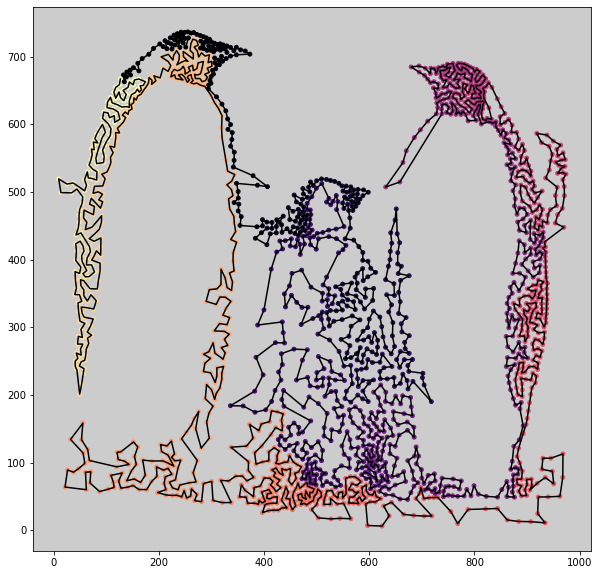

In [116]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
np.random.seed(0)
I = skimage.io.imread("/Users/will/Documents/Python-Projects/HW6_TSPArt-main/images/penguins.png")
# Initial stippling
X = voronoi_stipple(I, thresh=0.3, target_points=2000, canny_sigma=0.8)
# Filter out lowest 4 points by density
X = density_filter(X, (X.shape[0]-4)/X.shape[0]) 
'''
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], 2)
plt.savefig("penguins_stipple.svg", bbox_inches='tight')
'''
np.random.seed(0)
nodes, edges = make_delaunay_graph(X)
get_mst_kruskal(nodes, edges)
tour = dfs(nodes[0])
'''
plt.figure(figsize=(10, 10))
plt.plot(X[tour, 0], X[tour, 1], c='k')
plt.scatter(X[tour, 0], X[tour, 1], s=15, c=np.arange(len(tour)), cmap='magma_r')
plt.gca().set_facecolor((0.8, 0.8, 0.8))
'''
improve_tour(tour, X)

plt.figure(figsize=(10, 10))
plt.plot(X[tour, 0], X[tour, 1], c='k')
plt.scatter(X[tour, 0], X[tour, 1], s=15, c=np.arange(len(tour)), cmap='magma_r')
plt.gca().set_facecolor((0.8, 0.8, 0.8))


0


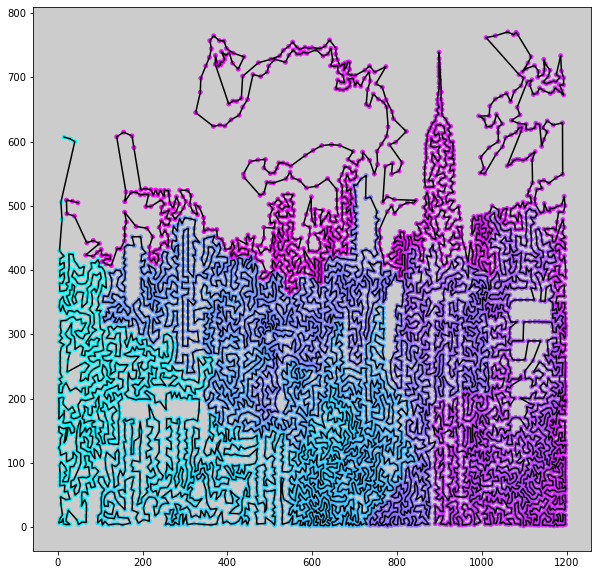

In [133]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io
np.random.seed(0)
I = skimage.io.imread("/Users/will/Documents/Python-Projects/HW6_TSPArt-main/images/manhattan.png")
# Initial stippling
X = voronoi_stipple(I, thresh=0.3, target_points=8000, canny_sigma=0.8)
# Filter out lowest 4 points by density
X = density_filter(X, (X.shape[0]-4)/X.shape[0])

np.random.seed(0)
nodes, edges = make_delaunay_graph(X)
get_mst_kruskal(nodes, edges)
tour = dfs(nodes[0])

improve_tour(tour, X)

plt.figure(figsize=(10, 10))
plt.plot(X[tour, 0], X[tour, 1], c='k')
plt.scatter(X[tour, 0], X[tour, 1], s=15, c=np.arange(len(tour)), cmap='cool')
plt.gca().set_facecolor((0.8, 0.8, 0.8))